In [191]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [192]:
#!pip install pandas
#!pip install tqdm

#!pip install scipy
#!pip install matchms
#!pip install scikit-learn
#!pip install spec2vec
#!pip install seaborn

In [193]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [194]:
from src.transformers.sklearn_model import SklearnModel

In [195]:
import gensim
from src.load_data import LoadData
from src.config import Config
from matchms import calculate_scores
from matchms.importing import load_from_mgf,load_from_msp
import matchms.filtering as msfilters
from spec2vec import SpectrumDocument
from torch.utils.data import DataLoader, WeightedRandomSampler
from spec2vec.model_building import train_new_word2vec_model
from tqdm import tqdm
from src.loader_saver import LoaderSaver
import itertools
from pytorch_lightning.callbacks import ProgressBar
from src.losscallback import LossCallback
import numpy as np
from matchms.importing import load_from_msp
from matchms.similarity import ModifiedCosine
from scipy.stats import spearmanr
import dill
from src.weight_sampling import WeightSampling
from src.plotting import Plotting
from torch.utils.data import DataLoader, WeightedRandomSampler
import lightning.pytorch as pl
from src.load_data import LoadData
from sklearn.model_selection import train_test_split
from src.train_utils import TrainUtils
from src.preprocessor import Preprocessor
from matchms.filtering import add_fingerprint
import pickle
import sys
from src.config import Config
from src.parser import Parser
from datetime import datetime
from src.loader_saver import LoaderSaver
from src.spec2vec_comparison import Spec2VecComparison
from src.ms2deepscore_comparison import MS2DeepScoreComparison
from src.molecule_pairs_opt import MoleculePairsOpt
from scipy.stats import spearmanr
from src.transformers.load_data import LoadData as LoadDataTrans
from src.transformers.load_data_unique import LoadDataUnique

In [196]:
from src.transformers.embedder import Embedder

In [197]:
ls /Users/sebas/projects/data

ALL_GNPS_NO_PROPOGATED_wb.mgf
GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf
all_spectrums_gnps.pkl
all_spectrums_gnps_nist_20240130_gnps_nist_janssen.pkl
all_spectrums_janssen.pkl
all_spectrums_nist.pkl
best_model.ckpt
best_model_128n_10_layers_20240209.ckpt
best_model_128n_5_layers_20240219_elementwise.ckpt
best_model_128n_5_layers_20240229.ckpt
best_model_128n_5_layers_20240303.ckpt
best_model_20240301.ckpt
drug_plus.mgf
hr_msms_nist_all.MSP*
hr_msms_nist_sample.MSP
merged_gnps_nist_20240118_gnps_nist_janssen.pkl
merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl
merged_gnps_nist_20240227_gnps_nist_janssen_20_millions_OUTSIDE_MAX_DIFF_NO_JANSSEN.pkl
merged_gnps_nist_20240311_unique_smiles_1_million.pkl
ms2deepscore_positive_10k_1000_1000_1000_500.hdf5
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.trainables.syn1neg.npy
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.wv.vectors.npy
to_export_gnps_nist.pk

## Parameters

In [198]:
data_folder= '/Users/sebas/projects/data/'
dataset_path = data_folder + 'uniformed_molecule_pairs_test.pkl'
gnps_path =  data_folder + 'ALL_GNPS_NO_PROPOGATED_wb.mgf'
janssen_path = data_folder + 'drug_plus.mgf'
nist_path = data_folder + 'hr_msms_nist_all.MSP'
output_pairs_file= data_folder + 'molecular_pairs.pkl'
output_nist_file= data_folder + 'all_spectrums_nist.pkl'
output_gnps_file= data_folder + 'all_spectrums_gnps.pkl'
output_janssen_file= data_folder + 'all_spectrums_janssen.pkl'
model_spec2vec_file = data_folder + 'spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model'
model_ms2d_file= data_folder + 'ms2deepscore_positive_10k_1000_1000_1000_500.hdf5'
#uniformed_molecule_pairs_test_path= data_folder +'uniformed_molecule_pairs_test.pkl'
#uniformed_molecule_pairs_test_path= data_folder +'merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl'
uniformed_molecule_pairs_test_path= data_folder + 'merged_gnps_nist_20240311_unique_smiles_1_million.pkl'
transformer_path = data_folder + 'best_model_128n_5_layers_20240219_elementwise.ckpt'

In [199]:
THRESHOLD_ANALOG=0.7

In [200]:
load_molecule_pairs_file= True
only_use_gnps=False

In [201]:
## Load spectrum using spectrumutils

In [202]:
config=Config()

In [203]:
config.CHECKPOINT_DIR = './notebooks/cosine/results'
config.use_cosine_distance=True

In [204]:
#config.LR=0.000001
#config.LR=0.000001

In [205]:
NUMBER_TRAIN_PAIRS=1000

## Load molecular pairs

In [206]:
uniformed_molecule_pairs_test_path

'/Users/sebas/projects/data/merged_gnps_nist_20240311_unique_smiles_1_million.pkl'

In [207]:

if load_molecule_pairs_file:
        with open(uniformed_molecule_pairs_test_path, 'rb') as file:
            dataset = dill.load(file)


In [208]:
molecule_pairs_train= dataset['molecule_pairs_train']
molecule_pairs_val= dataset['molecule_pairs_val']

In [209]:
molecule_pairs_train

In [210]:
molecule_pairs_val

## Our model

In [211]:
from src.transformers.sklearn_model import SklearnModel

In [212]:
# Generate an array of 10 random integers between 0 and 100
random_integers_train = np.random.randint(0, len(molecule_pairs_train), NUMBER_TRAIN_PAIRS)
random_integers_val = np.random.randint(0, len(molecule_pairs_val), NUMBER_TRAIN_PAIRS)

In [213]:
#molecule_pairs_train= MolecularPairsSet(spectrums= molecule_pairs_train.spectrums, 
#                                     indexes_tani =molecule_pairs_train.indexes_tani[random_integers_train])
#molecule_pairs_val= MolecularPairsSet(spectrums= molecule_pairs_val.spectrums, 
#                                      indexes_tani =molecule_pairs_val.indexes_tani[random_integers_val])
molecule_pairs_train= MoleculePairsOpt(
            spectrums_unique=molecule_pairs_train.spectrums,
            indexes_tani_unique= molecule_pairs_train.indexes_tani[random_integers_train],
            spectrums_original=molecule_pairs_train.spectrums_original,
            df_smiles=molecule_pairs_train.df_smiles,
        )
molecule_pairs_val= MoleculePairsOpt(
            spectrums_unique=molecule_pairs_val.spectrums,
            indexes_tani_unique= molecule_pairs_val.indexes_tani[random_integers_val],
            spectrums_original=molecule_pairs_val.spectrums_original,
            df_smiles=molecule_pairs_val.df_smiles,
        )

In [214]:
## CALCULATION OF WEIGHTS
train_binned_list, _ = TrainUtils.divide_data_into_bins(
    molecule_pairs_train, config.bins_uniformise_TRAINING,
)

In [215]:
weights, range_weights = WeightSampling.compute_weights(train_binned_list)

In [216]:
weights_tr = WeightSampling.compute_sample_weights(molecule_pairs_train, weights)
weights_val = WeightSampling.compute_sample_weights(molecule_pairs_val, weights)

In [217]:
molecule_pairs_train[0].similarity

0.5865128636360168

In [218]:
weights_tr[0]

0.0003102699348433123

In [219]:
molecule_pairs_train[0].similarity

0.5865128636360168

In [220]:
weights_tr[0]

0.0003102699348433123

In [221]:
dataset_train = LoadDataUnique.from_molecule_pairs_to_dataset(molecule_pairs_train, training=True)
# dataset_test = LoadData.from_molecule_pairs_to_dataset(m_test)
dataset_val = LoadDataUnique.from_molecule_pairs_to_dataset(molecule_pairs_val)

Preprocessing all the data ...



0it [00:00, ?it/s]
4178it [00:00, 41777.15it/s]
8356it [00:00, 26294.94it/s]
11305it [00:00, 24248.57it/s]
15447it [00:00, 29472.62it/s]
23119it [00:00, 43786.28it/s]
30542it [00:00, 52981.29it/s]
39563it [00:00, 64202.37it/s]
48370it [00:00, 71385.56it/s]
57955it [00:01, 78739.80it/s]
66896it [00:01, 81944.57it/s]
75654it [00:01, 83633.51it/s]
84137it [00:01, 83565.55it/s]
92577it [00:01, 83599.82it/s]
101002it [00:01, 83791.39it/s]
110167it [00:01, 86140.12it/s]
119130it [00:01, 87183.93it/s]
127870it [00:01, 87011.15it/s]
136624it [00:01, 87168.32it/s]
146107it [00:02, 89460.54it/s]
155391it [00:02, 90472.70it/s]
164445it [00:02, 89328.28it/s]
173624it [00:02, 90059.11it/s]
182636it [00:02, 88605.70it/s]
191660it [00:02, 89085.66it/s]
200596it [00:02, 89164.39it/s]
209518it [00:02, 88434.58it/s]
218809it [00:02, 89759.61it/s]
227942it [00:02, 90225.85it/s]
236969it [00:03, 89795.15it/s]
246177it [00:03, 90475.02it/s]
261349it [00:03, 78649.29it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries
Preprocessing all the data ...



0it [00:00, ?it/s]
4120it [00:00, 41193.95it/s]
12672it [00:00, 67263.73it/s]
21131it [00:00, 75170.03it/s]
31318it [00:00, 75448.90it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


In [222]:
next(iter(dataset_train))

{'mz_0': array([ 487.2876 ,  501.3247 ,  511.0946 ,  546.17084,  594.27673,
         613.41187,  631.3617 ,  639.4408 ,  648.3034 ,  650.2898 ,
         667.0106 ,  674.3987 ,  676.19104,  679.2742 ,  693.2126 ,
         696.28845,  704.2888 ,  714.42664,  734.59766,  735.302  ,
         739.4862 ,  740.4333 ,  757.40735,  763.40295,  772.2491 ,
         775.2638 ,  809.45105,  828.2229 ,  830.0985 ,  844.302  ,
         847.4253 ,  848.27795,  855.4614 ,  862.3174 ,  863.2672 ,
         865.35913,  872.3269 ,  873.34595,  874.30554,  885.324  ,
         889.64636,  890.3447 ,  891.4215 ,  894.21375,  903.2715 ,
         908.266  ,  909.09314,  917.4026 ,  935.4773 ,  943.2938 ,
         950.4313 ,  961.2501 ,  970.47046,  984.39514,  988.29333,
         989.515  , 1014.4011 , 1032.6807 , 1033.3846 , 1034.5304 ,
        1043.5035 , 1050.5785 , 1061.2235 , 1068.3173 , 1070.6763 ,
        1071.3514 , 1072.5104 , 1073.3938 , 1083.5868 , 1084.5715 ,
        1085.3792 , 1086.719  , 1087.611

In [223]:
train_sampler = WeightedRandomSampler(
    weights=weights_tr, num_samples=len(dataset_train), replacement=True
)
val_sampler = WeightedRandomSampler(
    weights=weights_val, num_samples=len(dataset_val), replacement=True
)


In [224]:
dataloader_train = DataLoader(
    dataset_train, batch_size=config.BATCH_SIZE,  num_workers=10, sampler=train_sampler,
)
def worker_init_fn(
    worker_id,
):  # ensure the dataloader for validation is the same for every epoch
    seed = 42
    torch.manual_seed(seed)
    # Set the same seed for reproducibility in NumPy and Python's random module
    np.random.seed(seed)
    random.seed(seed)

dataloader_val = DataLoader(
    dataset_val,
    batch_size=config.BATCH_SIZE,
    num_workers=0,
    sampler=val_sampler,
)


In [225]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=config.CHECKPOINT_DIR,
    filename="best_model",
    monitor="validation_loss_epoch",
    mode="min",
    save_top_k=1,
)

# checkpoint_callback = SaveBestModelCallback(file_path=config.best_model_path)
progress_bar_callback = ProgressBar()

# loss callback
losscallback = LossCallback(file_path=config.CHECKPOINT_DIR + f"loss.png")

print("define model")


    
model = Embedder(
        d_model=int(config.D_MODEL),
        n_layers=int(config.N_LAYERS),
        weights=None,
        lr=config.LR,
        use_cosine_distance=config.use_cosine_distance,
    )

define model
Using cosine library from Pytorch?: True


In [226]:
config.LR

0.0001

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/sebas/projects/metabolomics/notebooks/cosine/results exists and is not empty.

  | Name                    | Type                             | Params
-----------------------------------------------------------------------------
0 | linear                  | Linear                           | 16.5 K
1 | linear_regression       | Linear                           | 129   
2 | fixed_linear_regression | FixedLinearRegression            | 129   
3 | relu                    | ReLU                             | 0     
4 | spectrum_encoder        | SpectrumTransformerEncoderCustom | 1.7 M 
5 | regression_loss         | MSELoss                          | 0     
6 | dropout                 | Dropou

Sanity Checking: |                                                                                            …

/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train loss:
[]
Validation loss
[0.44289034605026245]


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Train loss:
[]
Validation loss
[0.44289034605026245, 0.20524878799915314]


Validation: |                                                                                                 …

Train loss:
[0.145171657204628]
Validation loss
[0.44289034605026245, 0.20524878799915314, 0.15635298192501068]


Validation: |                                                                                                 …

Train loss:
[0.145171657204628, 0.08867879211902618]
Validation loss
[0.44289034605026245, 0.20524878799915314, 0.15635298192501068, 0.12618973851203918]


Validation: |                                                                                                 …

Train loss:
[0.145171657204628, 0.08867879211902618, 0.08060254901647568]
Validation loss
[0.44289034605026245, 0.20524878799915314, 0.15635298192501068, 0.12618973851203918, 0.11932121962308884]


Validation: |                                                                                                 …

Train loss:
[0.145171657204628, 0.08867879211902618, 0.08060254901647568, 0.07112380117177963]
Validation loss
[0.44289034605026245, 0.20524878799915314, 0.15635298192501068, 0.12618973851203918, 0.11932121962308884, 0.13761559128761292]


Validation: |                                                                                                 …

Train loss:
[0.145171657204628, 0.08867879211902618, 0.08060254901647568, 0.07112380117177963, 0.07323632389307022]
Validation loss
[0.44289034605026245, 0.20524878799915314, 0.15635298192501068, 0.12618973851203918, 0.11932121962308884, 0.13761559128761292, 0.1287635713815689]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x129c5fb00>
Traceback (most recent call last):
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/multiprocessing/connection.py", line 947, in wait
    ready = selector.

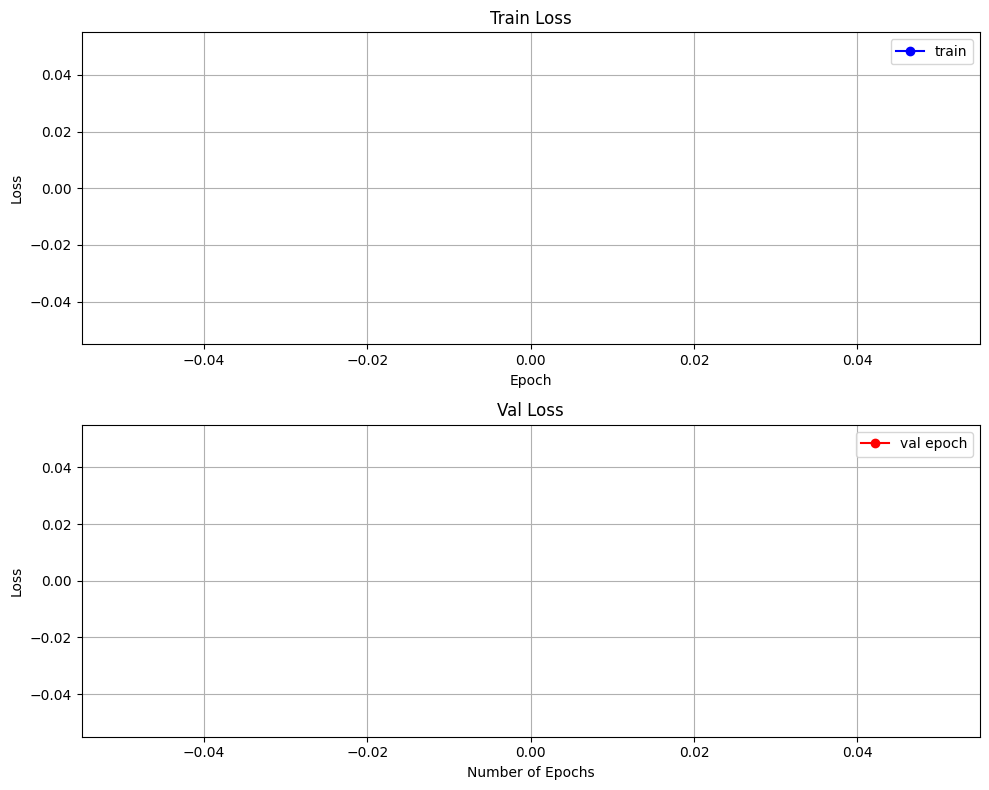

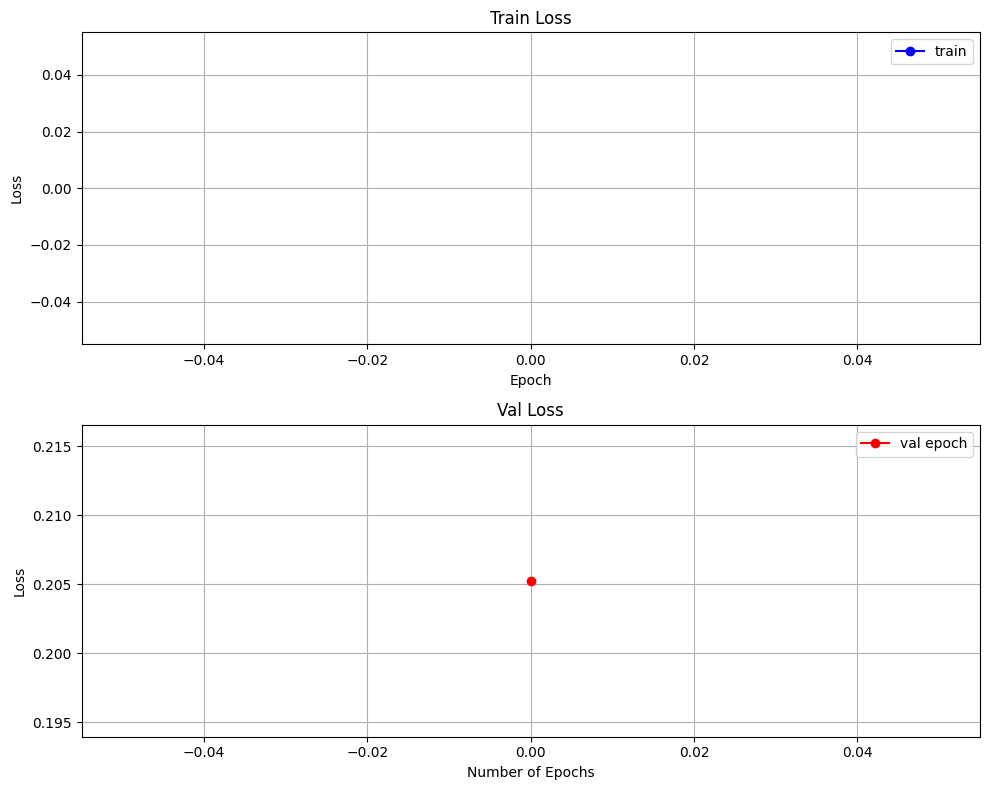

Error in callback <function flush_figures at 0x411fa7880> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



In [227]:
trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[checkpoint_callback, losscallback],
    enable_progress_bar=True,
    # val_check_interval= config.validate_after_ratio,
)
# trainer = pl.Trainer(max_steps=100,  callbacks=[checkpoint_callback, losscallback], enable_progress_bar=enable_progress_bar)
trainer.fit(
    model=model,
    train_dataloaders=(dataloader_train),
    val_dataloaders=dataloader_val,
)

In [ ]:
for name, param in model.named_parameters():
    print(name)
    print(param)